In [210]:
import numpy as np
from sklearn.datasets import make_classification
import time
from math import exp
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
X, y = make_classification(n_samples=1000)


In [293]:
sigmoid = lambda z : 1 / (1 + np.exp(-z))
logloss = lambda y_hat, y : np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) / len(y_hat)
# logloss = lambda y_hat, y : np.sum(-y * (y_hat) + np.log(1 + np.exp(y_hat))) / len(y_hat)
predict = lambda X: sigmoid(np.dot(X, betas.T)) > .5
predict_with_output = lambda X: (X > .5) * 1


def gradient_descent(X, y, beta, lr):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    new_betas = beta - lr * gradients.T

    return new_betas, gradients

def momentum_descent(X, y, beta, lr, prev_grad, alpha=0.99):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    new_betas = beta - lr * gradients.T + alpha * prev_grad.T

    return new_betas, gradients

def saga_descent(X, y, beta, lr, grad, idx):
    y = y.reshape(-1, 1)
    gradients = np.dot(X.T, sigmoid(np.dot(X, beta.T)) - y) / len(y)
    grad[idx] = gradients
    d = np.sum(np.array(grad),axis=0)
    new_betas = beta - (lr / len(grad)) * d.T
    
    return new_betas, grad
    
    

def prepare_batches(X, y, batch_size):
    X_batch_list = list()
    y_batch_list = list()
    
    for i in range(len(y) // batch_size):
        X_batch_list.append(X[i * batch_size : i * batch_size + batch_size, :])
        y_batch_list.append(y[i * batch_size : i * batch_size + batch_size])
    
    if len(y) % batch_size > 0:
        X_batch_list.append(X[len(y) // batch_size * batch_size:, :])
        y_batch_list.append(y[len(y) // batch_size * batch_size:])

    return X_batch_list, y_batch_list

In [294]:
permutations = np.random.permutation(len(X))

X, y = np.asarray(X).squeeze(), np.asarray(y)

X = X[permutations, :]
y = y[permutations]

# To add beta 0
# temp = np.ones((X.shape[0], X.shape[1] + 1))
# temp[:, 1:] = X
# X = temp

len_test = len(X) // 5 
len_train = len(X) - len_test
X_test, y_test, X_train, y_train = X[:len_test, :], y[:len_test], X[len_test:, :], y[len_test:]

In [295]:
print("Shape of X matrix is: " + str(X.shape))
print("Shape of y matrix is: " + str(y.shape))
print("Shape of X_test matrix is: " + str(X_test.shape))
print("Shape of y_test matrix is: " + str(y_test.shape))
print("Shape of X_train matrix is: " + str(X_train.shape))
print("Shape of y_train matrix is: " + str(y_train.shape))

print("Desired samples feature vector: " + str(X[2]))
print("Desired samples ground truth: " + str(y[2]))

Shape of X matrix is: (1000, 20)
Shape of y matrix is: (1000,)
Shape of X_test matrix is: (200, 20)
Shape of y_test matrix is: (200,)
Shape of X_train matrix is: (800, 20)
Shape of y_train matrix is: (800,)
Desired samples feature vector: [-0.25536373 -0.92173955 -1.18054918  1.37790864  1.24350878  1.63002292
 -0.88277691 -0.7927288  -1.28437689  1.12022305  0.76467539 -0.79043067
  0.30278401  0.67132107  1.93594254 -1.07051261 -0.58200852  0.91998791
 -1.38465309  0.66368946]
Desired samples ground truth: 0


In [296]:
def BGD(X_train,y_train,lr,max_iter,epi=1e-6,patience=2,momentum=False,saga=False):
    train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train=X_train,
                                                            y_train=y_train,
                                                            lr=lr,
                                                            batch_size=X_train.shape[0],
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,
                                                            momentum=momentum,
                                                            saga=saga)
    return train_error_hist, test_error_hist, test_acc_hist


def SGD(X_train,y_train,lr,max_iter,epi=1e-6,patience=2,momentum=False,saga=False):
    train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train=X_train,
                                                            y_train=y_train,
                                                            lr=lr,
                                                            batch_size=1,
                                                            max_iter=max_iter,
                                                            epi=epi,
                                                            patience=patience,
                                                            momentum=momentum,
                                                            saga=saga)
    return train_error_hist, test_error_hist, test_acc_hist

def MBGD(X_train,y_train,lr,batch_size,max_iter,epi=1e-6,patience=2,momentum=False,saga=False):
    train_error_hist = list()
    test_error_hist = list()
    test_acc_hist = list()

    betas = np.random.random(X.shape[1]).reshape(1, -1)

    prev_average = np.inf

    patience_counter = 0
    iteration_counter = 0
    
    if saga:
        grad = list()
        sagaFlag = True
            
    if momentum: 
        grad = np.random.random(X.shape[1]).reshape(1, -1).T
    
    while iteration_counter < max_iter:
        lr = 1. / (2*iteration_counter+1.)
        if saga==False:
            X_train, y_train = shuffle(X, y, random_state=0)
        X_batch_list, y_batch_list = prepare_batches(X_train, y_train, batch_size)
        n_batches = len(y_batch_list)

            
        for i in range(n_batches):
            X_batch = X_batch_list[i]
            y_batch = y_batch_list[i]
            
            if momentum:
                betas, grad = momentum_descent(X_batch, y_batch, betas, lr, grad)
            else:
                if (saga and sagaFlag==False):
                    betas, grad = saga_descent(X_batch, y_batch, betas, lr, grad, i)
                else:
                    betas, gd = gradient_descent(X_batch, y_batch, betas, lr)
                
                if (saga and sagaFlag):
                    grad.append(gd)
                

            y_hat = sigmoid(np.dot(X_batch, betas.T))
            train_error_hist.append(logloss(y_hat, y_batch) / len(y_batch))

            y_hat = sigmoid(np.dot(X_test, betas.T))
            test_error_hist.append(logloss(y_hat, y_test) / len(y_test))
            test_acc_hist.append(np.mean((predict_with_output(y_hat) == y_test.reshape(-1, 1)) * 1))

            iteration_counter += 1

        current_average = np.mean(train_error_hist[-n_batches:])
        
        if saga:
            sagaFlag = False

        if np.abs(prev_average - current_average) < epi:
            patience_counter += 1
        else:
            patience_counter = 0

        prev_average = current_average

        if patience_counter == patience:
            break
    return  train_error_hist, test_error_hist, test_acc_hist


In [275]:
train_error_hist, test_error_hist, test_acc_hist = MBGD(X_train,y_train,lr=0.01,batch_size=512,max_iter=1000,epi=1e-6,patience=2)

In [271]:
train_error_hist, test_error_hist, test_acc_hist = BGD(X_train,y_train,lr=0.01,max_iter=1000,epi=1e-6,patience=2)

In [297]:
train_error_hist, test_error_hist, test_acc_hist = SGD(X_train,y_train,lr=0.01,max_iter=1000,epi=1e-6,patience=2,momentum=False,saga=True)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


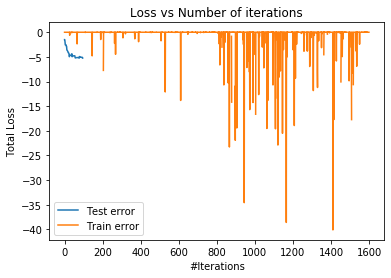

In [298]:
plt.plot(test_error_hist)
plt.plot(train_error_hist)
plt.xlabel("#Iterations")
plt.ylabel("Total Loss")
plt.title("Loss vs Number of iterations")
plt.legend(("Test error", "Train error"))

Text(0.5, 1.0, 'Accuracy vs Number of iterations')

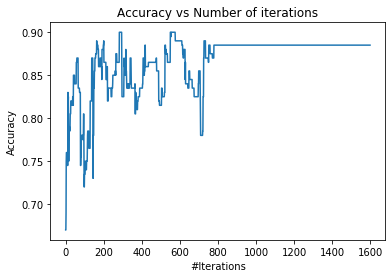

In [299]:
plt.plot(test_acc_hist)
plt.xlabel("#Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of iterations")

In [126]:
from random import seed
from random import randrange
from csv import reader
from math import exp
import numpy as np
import time
# from multiprocessing import Pool
from multiprocessing import Pool as ThreadPool


# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax

# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

# Test the logistic regression algorithm on the diabetes dataset
seed(1)
# load and prepare data
filename = 'pima-indians-diabetes.csv'
dataset = load_csv(filename)
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)
# normalize
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
X = np.array(dataset)[:,:-1]
y = np.array(dataset)[:,-1]